### Objectives
- The objective of this notebook is to start with modelling the data with Random Forest 
- Explain Random Forest 

In [365]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


from sklearn import preprocessing
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import os
from pandas_summary import DataFrameSummary
from matplotlib import pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import re

import shap
import eli5
from eli5.sklearn import PermutationImportance
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split


from sklearn.metrics import roc_auc_score
import time

In [366]:
train = pd.read_csv("Modeltrain.csv")
test = pd.read_csv("Modeltest.csv")

Columns (11,14) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.


### Filling nan data 

In [367]:
train[["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]] = train[["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]].fillna("Unknown")
test[["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]] = test[["P_emaildomain_bin","P_emaildomain_suffix","R_emaildomain_bin","R_emaildomain_suffix"]].fillna("Unknown")

In [382]:
V_vars = columns_names("V",1,339)

In [384]:
train[V_vars] = train[V_vars].fillna(-999)
test[V_vars] = test[V_vars].fillna(-999)

In [385]:
print("Train shape",train.shape)
print("Test shape",test.shape)

Train shape (590540, 443)
Test shape (506691, 443)


In [ ]:
for i in C:
    test = imputer(test,i,"mode")

## Data Preprocessing 

In [370]:
is_Fruad = train["isFraud"]
train = train.drop(["isFraud"],axis=1)

In [374]:
for f in tqdm(train.columns):
    if train[f].dtype=='object' or test[f].dtype=='object':
        train[f] = train[f].fillna('unseen_before_label')
        test[f] = test[f].fillna('unseen_before_label')
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))
        train[f] = train[f].astype('category')
        test[f] = test[f].astype('category')

   

100%|████████████████████████████████████████████████████████████████████████████████| 443/443 [00:44<00:00, 10.01it/s]


In [375]:
 print(f'train.shape : {train.shape}, test.shape : {test.shape}')

train.shape : (590540, 443), test.shape : (506691, 443)


In [405]:
train = train.drop(["Unnamed: 0","Unnamed: 0.1","TransactionID","TransactionID"],axis=1)
test = test.drop(["Unnamed: 0","Unnamed: 0.1","TransactionID","TransactionID"],axis=1)

In [422]:
train = train.drop(["TransactionAmt_log","TransactionDT","trans_dt"],axis=1)
test = test.drop(["TransactionAmt_log","TransactionDT","trans_dt"],axis=1)

### Train and Test Split 

In [423]:
X_train, X_val, Y_train, Y_val = train_test_split(train,is_Fruad, 
                                                    test_size=0.15, 
                                                    random_state=42)

In [424]:
random_forest = RandomForestClassifier(n_jobs=-1)
random_forest.fit(X_train,Y_train)
feature =pd.DataFrame(random_forest.feature_importances_,columns=["Impotance"])
feature["features"]= random_forest.feature_names_in_
feature = feature.sort_values(by = "Impotance",ascending=False)

In [483]:
print("Validation roc_auc_score",roc_auc_score(Y_val,random_forest.predict_proba(X_val)[:,1] ))

Validation roc_auc_score 0.92995103122914


In [469]:
Y_pred = random_forest.predict_proba(test)[:,1]
sample = pd.read_csv("sample_submission.csv")
sample["isFraud"] = Y_pred
sample.to_csv("Baseline_randomforest.csv",index = False)

**Kaggle Score : 0.873164**

### Tackling the Imbalance Class

#### Oversample minority class 

In [485]:

from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

In [500]:
X=pd.concat([train,is_Fruad],axis=1)
not_fraud=X[X.isFraud==0]
fraud=X[X.isFraud==1]

In [505]:
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27)
upsampled = pd.concat([not_fraud, fraud_upsampled])


In [506]:
upsampled.isFraud.value_counts()

0    569877
1    569877
Name: isFraud, dtype: int64

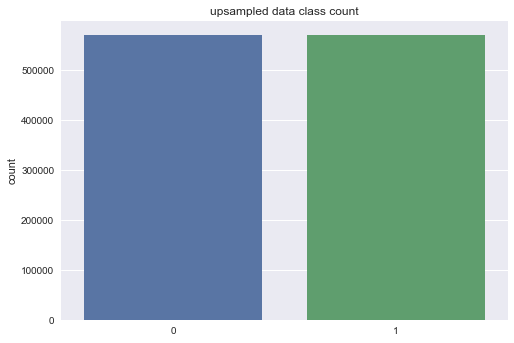

In [507]:
y=upsampled.isFraud.value_counts()
sns.barplot(y=y,x=[0,1])
plt.title('upsampled data class count')
plt.ylabel('count')
plt.show()

In [510]:
y = upsampled["isFraud"]
upsampled = upsampled.drop(["isFraud"],axis=1)


In [511]:
X_train, X_val, Y_train, Y_val = train_test_split(upsampled,y, 
                                                    test_size=0.15, 
                                                    random_state=42)

In [513]:
random_forest_up = RandomForestClassifier(n_jobs=-1)
random_forest_up.fit(X_train,Y_train)


RandomForestClassifier(n_jobs=-1)

In [514]:
print("Validation roc_auc_score",roc_auc_score(Y_val,random_forest_up.predict_proba(X_val)[:,1] ))

Validation roc_auc_score 1.0


In [515]:
feature =pd.DataFrame(random_forest_up.feature_importances_,columns=["Impotance"])
feature["features"]= random_forest_up.feature_names_in_
feature = feature.sort_values(by = "Impotance",ascending=False)

In [ ]:
Y_pred = random_forest_up.predict_proba(test)[:,1]
sample["isFraud"] = Y_pred
sample.to_csv("Baseline_uprandomforest.csv",index = False)

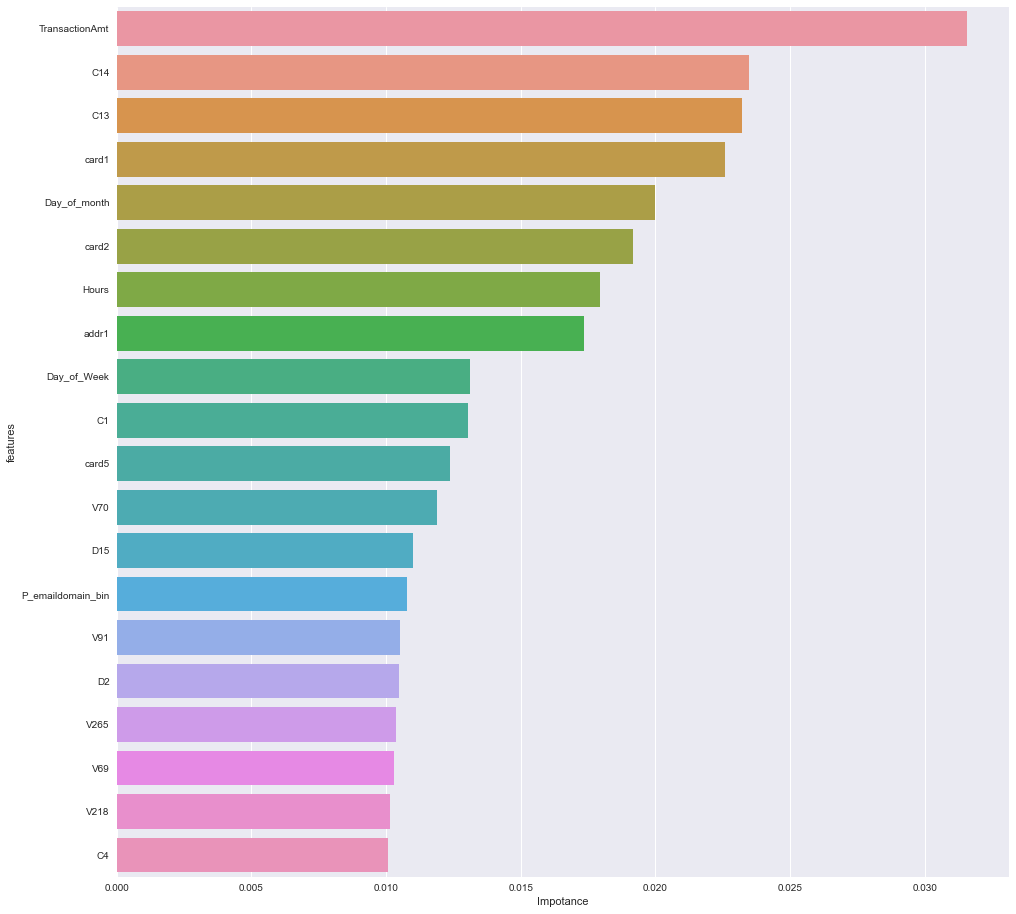

In [529]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature[:20], x='Impotance', y='features');


## Kaggle Score : 0.898136 